In [1]:
# reload magics
%load_ext autoreload
%autoreload 2

## IMPORTS

In [2]:
import colorcet as cc
import logging
import matplotlib.colors as mc
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib.axes import Axes

from hdbscan import all_points_membership_vectors, HDBSCAN
from umap import UMAP

from copy import deepcopy, copy

from upsetplot import from_memberships, plot, UpSet, from_indicators

from typing import Dict, List, Tuple, Optional

palette = cc.glasbey_hv

# create a palette dictionary that has the same keys as the original palette
palette_dict = {i: mc.to_hex(palette[i]) for i in range(len(palette))} # type: ignore

# add an entry for -1
palette_dict[-1] = '#ffffff'

# set default colour for seaborn heatmaps
sns.set_theme(style = "whitegrid", rc={'figure.figsize':(8,8)}, palette='viridis')

# make a matplotlib cmap from limegreen to white
from matplotlib.colors import LinearSegmentedColormap

cmap = LinearSegmentedColormap.from_list("limegreen-white", 
                                         ["white", "limegreen"])



FONTSIZE = 24

In [3]:
# heatmap parms
heatmap_parms = {
                'cbar': False,
                'square': False,
                'linewidths': 0.5,
                'linecolor': 'black',
                'center': 0.0,
                'vmin': -1,
                'vmax': 1,
                # 'annot': False,
                'fmt': '.2f',
}

# from the data dictionary
site_name_dict = {
                  1: 'LDN',
                  2: 'MTL',
                  3: 'SAN',
                  4: 'RIO',
                  5: 'LUS',
}
# from the data dictionary
site_fullname_dict = {
                  'LDN': "London",
                  'MTL': "Montreal",
                  'SAN': "San Diego",
                  'RIO': "Rio de Janeiro",
                  'LUS': "Lusaka",
}

# assign consistent styles
site_style_dict = {
              1: 'o',
              2: 'D',
              3: 'P',
              4: 'X',
              5: 's',
}

In [4]:
figdir    = "./OUTPUT/lc-pos-figures"
reportdir = "../lc2-report"
data_dir  = "../lc-project-data"

## FUNCTIONS

In [5]:
#===============================================================================
def compare_two_clusters(df, a, b):
#===============================================================================
# a function to compare two clusters - returns the concatenated cluster data for further analysis

    subset_a = df.query(f"cluster == {a}")
    subset_b = df.query(f"cluster == {b}")

    index_a = subset_a.index
    index_b = subset_b.index

    df_a = df.loc[index_a]
    df_b = df.loc[index_b]

    # concatenate
    df_ab = pd.concat([df_a, df_b])

    # cast cluster to int
    df_ab["cluster"] = df_ab["cluster"].astype(int)

    return df_ab


In [6]:
#===============================================================================
def make_centroids(e, lbls):
#===============================================================================

    # assume that lbls is a pandas series
    if isinstance(lbls, pd.Series):
        lbls = lbls.values
    


    # get the centroids of the umap coordinates by cluster
    centroids = pd.DataFrame(e, 
                                columns = ["x", "y"]).assign(cluster = lbls).groupby("cluster").mean()
    return centroids


#===============================================================================
def make_plot_df(embeddings, clusterer, index, sites):
#===============================================================================

    d = pd.DataFrame(embeddings, columns = ["x", "y"], index = index)
    d["Cluster"]             = clusterer.labels_
    d["Cluster Confidence"]  = clusterer.probabilities_


    try:
        d["Most Likely Cluster"] = np.argmax(all_points_membership_vectors(clusterer), axis = 1)
    except (KeyError, AttributeError):
        d["Most Likely Cluster"] = clusterer.labels_


    # EXPT

    d["Site"]                = sites


    return d



In [7]:
#===============================================================================
def plot_clusters(
                    df: pd.DataFrame, 
                    site_name_dict: dict,
                    centroids: Optional[bool] = False, 
                    title: Optional[str] = None,
                      most_likely: bool = False,
                      size_by_prob: bool = False,
                      ax: Optional[Axes] = None,
                      FONTSIZE: int = 24,
                      ):
#===============================================================================

    # plot the embeddings
    # fig, ax = plt.subplots(figsize=(10, 10))

    if ax == None:
        fig, ax = plt.subplots(figsize=(10, 10))
    else:
        fig = None
        ax = ax
        pass


    if most_likely:
        hue = "Most Likely Cluster"
    else:
        hue = "Cluster"

    if size_by_prob:
        size = "Cluster Confidence"
    else:
        size = None

    sns.scatterplot(data = df, 
                    x = "x",
                    y = "y",
                    s = 150,
                    edgecolor = 'black', 
                    hue       = hue,
                    linewidth = 0.5, 
                    palette   = palette_dict,
                    style     = "Site",
                    style_order = site_name_dict.values(),
                    markers = ['o','D', 'P', 'X', 's'],
                    size      = size,
                    # size      = "Cluster Confidence",
                    ax = ax
                        )

    if centroids is not None:
        # plot centroids
        if centroids == True:
            centroids = make_centroids(df[["x", "y"]].values, df["Cluster"])
            plot_centroids(centroids, ax, palette_dict = None)

    # set title
    if title:
        plt.title(title)

    # place the legend outside to the right of the plot
    plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

    # turn off axis labels and ticks
    if ax == None:
        plt.xticks([]); plt.yticks([]);
        plt.xlabel(""); plt.ylabel("");

        # make labels larger
        plt.tick_params(axis='both', which='major', labelsize=16)

        # make the legend larger
        plt.setp(ax.get_legend().get_texts(), fontsize='24') # for legend text
        plt.setp(ax.get_legend().get_title(), fontsize='24') # for legend title

    # turn off x and y axis labels
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    # turn off grid
    ax.grid(False)
    
    # axis labels
    ax.set_xlabel("Dimension 1", fontsize = FONTSIZE)
    ax.set_ylabel("Dimension 2", fontsize = FONTSIZE)


    # make the legend larger
    plt.setp(ax.get_legend().get_texts(), fontsize=FONTSIZE-2) # for legend text
    plt.setp(ax.get_legend().get_title(), fontsize=FONTSIZE-2) # for legend title


    # return fig, ax

#===============================================================================
def plot_centroids(centroids, 
                   ax, 
                   alpha = 1.0, 
                   palette_dict = None, 
                   fontsize = 24,
                   show_edge = False,
                   ):
#===============================================================================
    # plot the centroids



    for i, centroid in centroids.iterrows():

        # don't plot the -1 cluster
        if i != -1:

            # plot in colour, if passed in
            if palette_dict is not None:
                ec = palette_dict[i]
            else:
                ec = 'w'

            if show_edge:
                ec = 'black'

            ax.annotate(
                        i,
                        (centroid.x, centroid.y), 
                        ha='center',
                        va='center',
                        bbox=dict(boxstyle="round,pad=0.3", 
                                    fc="k", 
                                    # ec="#ababab",
                                    ec = ec,
                                    # ec="w",
                                    # fc="white", 
                                    # ec="black",
                                    lw=2, 
                                    alpha=alpha,
                                    ),
                        fontsize = fontsize,
                        color = 'white',
                        # make font bold
                        fontweight = "bold",
                        )



In [8]:
#===============================================================================
def make_upset_data(df, 
                    ftrs, 
                    method = "mean", 
                    add_column = None,
                    keep_features = False):
#===============================================================================

    if method not in ["mean", "median"]:
        print(f"Method {method} not supported.")

    else:
        if method == "mean":
            new_df = df[ftrs] > df[ftrs].mean(axis = 0)
        # elif method == "median":
        else:
            new_df = df[ftrs] > df[ftrs].median(axis = 0)

    new_df = new_df[ftrs]
    new_df.rename(columns= {c: f">{c}" for c in ftrs}, inplace = True)

    df2 = pd.concat([df, new_df, add_column], axis = 1) # type: ignore
    # if keep_features == True:
    #     pass
    # else:
    #     df2 = df2.set_index(list(new_df.columns))

    return df2

In [9]:
#===============================================================================
def excursion_plot(d, 
                    method = "mean",
                    grouper = "cluster",
                    style: str = "binary",
                    # figsize = (6,64),
                    ax = None,
                    cmap = cc.cm.bjy,
                    top_n = None,
                    ):
#===============================================================================

    # TODO: colour map to match the cluster thumbnails
    # TODO: drop age, sex

    norm = None

    # qq.astype(int)
    if ax == None:
        fig, ax = plt.subplots()
    else:
        ax = ax


    # find all object columns and drop them
    d = d.select_dtypes(exclude = "object")

    # set the figsize to scale with the number of features
    figsize = (6, d.shape[1] / 5)

    # get the global median for each feature
    global_median = d.median()
    global_mean   = d.mean()

    globals = pd.concat([global_median, global_mean], axis = 1)
    globals.columns = ["Ensemble Median", "Ensemble Mean"]

    globals.drop(grouper, inplace = True)


    # per feature mean and median
    mm_mean   = d.groupby(grouper).mean().T
    mm_median = d.groupby(grouper).median().T

    # which version?
    if method == "mean":
        mm = mm_mean
        selector = "Ensemble Mean"
    elif method == "median":
        mm = mm_median
        selector = "Ensemble Median"
    else:
        print(f"Method {method} not supported.")
        

    if top_n is not None:
        mm = mm[:top_n]

    if style == "cont":
        # do the basic plot of means or medians
        # colourmap
        # cmap = cc.cm.bjy
        # fig, ax = plt.subplots(figsize=figsize)

        # heatmsp
        sns.heatmap(mm, 
                        cmap = cmap, 
                        ax   = ax, 
                        **heatmap_parms, 
                        norm = norm, 
                        annot = True,
                        annot_kws = {"fontsize": 8}
                        )

        plt.title(f"Excursion Plot: Feature {str.title(method)} by Cluster")
        plt.yticks(fontsize = 8);
        qq = None

    else:
        # mm is the mean or median per cluster per feature
        qq = pd.DataFrame(index = mm.index, columns = mm.columns)

        # for each cluster c in mm, 
        for c in mm.columns:
            # for each feature in this cluster, compare to the respective global mean
            for i, v in enumerate(mm[c].values):
                # is this cluster's mean or median greater than 
                # the global ensemble mean or median?
                # this will fill qq with true/false
                qq.loc[qq.index[i],c] = v >  globals.loc[qq.index[i], selector] # type: ignore

        # # qq.astype(int)
        # fig, ax = plt.subplots(figsize=figsize)

        sns.heatmap(qq.astype(int), 
                    # cmap = cc.bjy, 
                    cmap = cmap,
                    ax = ax, 
                    cbar = False, 
                    vmin = 0, 
                    linewidth = 0.5, 
                    square = False, 
                    linecolor = 'k'
                    )

        plt.yticks(fontsize = 8);
        plt.title(f"Excursion Plot: {str.title(grouper)} {str.title(method)} > {selector}")

    return globals, qq

In [10]:
#===============================================================================
def plot_cluster_by_site(src,
                         data,
                         labels,
                        site_name_dict: dict,

                         title: str,
                         tag: str,
                         ):
#===============================================================================

    # make a copy of the source data
    site_g = src.copy()

    # augment with cluster labels
    site_g.loc[data.index, "cluster"] = labels["Cluster"]

    # group and count
    cluster_by_site = site_g.groupby("cluster")["SITE"].value_counts().unstack().T

    # fill missing values
    cluster_by_site = cluster_by_site.fillna(0).astype(int)

    # map SITE values using site-name_dict

    cluster_by_site.index = cluster_by_site.index.map(site_name_dict)



    # rename columns
    cluster_by_site.columns = cluster_by_site.columns.astype(int)
    # cluster_by_site = cluster_by_site.loc[site_name_dict.values()]

    # sort index alphabetically
    

    fig, ax = plt.subplots(figsize=(8,8), layout = "constrained")

    sns.heatmap(cluster_by_site, 
                robust     = True, 
                ax         = ax, 
                annot      = True, 
                fmt        = "d", 
                cmap       = "viridis", 
                square     = True, 
                linewidths = 0.5, 
                linecolor  = "w", 
                cbar       = False)

    # rename axis labels
    plt.xlabel("Cluster")
    plt.ylabel("Site")
    plt.title(title)

    # fn = f"cluster-membership-umap-{tag}.png"
    # p = f"{figdir}/{fn}"

    # plt.savefig(p, dpi = 300, bbox_inches = 'tight')


In [11]:
#===============================================================================
def plot_multiple_features(
                            d: pd.DataFrame,
                            X: pd.DataFrame,
                            plot_df: pd.DataFrame,
                            feature_map: dict,
                            highlight_colour: str = "red",
                            ax = None,
                            subfig_label = None,
            ):
#===============================================================================
    
    
    sympt_dict = {0:"Absent", 1:"Present"}

    max_feature_length = min(20, len(dd))


    int_feat = d["Feature"][:max_feature_length]

    if ax is not None:
        pass
    else:
        fig, ax = plt.subplots(4, 5, 
                                figsize=(20, 20), 
                                sharex = True, 
                                sharey = True, 
                                layout = "constrained")

    ax  = ax.flatten()

    centroids = make_centroids(plot_df[["x", "y"]].values, plot_df["Cluster"])

# plot the features by cluster
    for i, f in enumerate(int_feat):
        the_ax = ax[i]


        if i == 0: 
            # add an annotation
            the_ax.annotate(subfig_label,
                        xy=(0, 1.01), 
                        xycoords='axes fraction',
                        xytext=(0.0,0.0), 
                        textcoords = 'offset points',
                        fontsize = FONTSIZE*2,
                        horizontalalignment='center', 
                        verticalalignment='bottom',
                        fontweight = "bold",

                        )



        if f == "age":
            plot_df[f] = X[f]
            the_palette = 'magma'
            hue_order = None

        elif f == "sex":
            plot_df[f] = X[f].map({0: "Male", 1:"Female"})
            the_palette = ["#ababab", "#5577aa"]
            hue_order = ["Male", "Female"]

        else:
            plot_df[f] = X[f].map(sympt_dict)
            the_palette = ['white', highlight_colour]
            hue_order = ["Absent", "Present"]


        sns.scatterplot(data = plot_df, 
                    x         = "x", 
                    y         = "y", 
                    hue       = f,
                    hue_order = hue_order,
                    palette   = the_palette, 
                    style     = "Site", 
                    style_order = site_name_dict.values(), 
                    markers   = list(site_style_dict.values()),
                    edgecolor = 'k', 
                    linewidth = 0.125, 
                    s         = 20, 
                    # alpha     = 0.75,
                    ax        = the_ax
                    )

        # add centroids for reference
        plot_centroids(centroids, the_ax, alpha = 0.35, show_edge = True)

        # turn off the ticks on the ax
        the_ax.set_xticks([]); the_ax.set_yticks([])
        the_ax.set_xlabel(""); the_ax.set_ylabel("")

        # set axis title
        the_ax.set_title(feature_map[f], fontsize = FONTSIZE - 2)

        # turn off the legnd on the ax
        the_ax.legend().remove()

    # set aspect ratio to 1
    # the_ax.set_aspect('equal')

    # plt.show()

    # return fig, ax


In [12]:
#===============================================================================
def plot_feature_importances(
                            features20: pd.DataFrame,
                            feature_map: dict,
                            feature_colour_map: dict,
                            ax,
                            FONTSIZE: int = 24,
                            ):
#===============================================================================
    
    # second, plot the feature importances in the "bars" window
    sns.barplot(
                    y       = features20["Feature"], 
                    x       = features20["Importance"],
                    palette = feature_colour_map,
                    hue     = features20["Feature"],
                    # orient = "h",
                    ax = ax,
                    # legend = None,
                    )

    # make the x ticks and label larger
    ax.tick_params(axis='both', which='major', labelsize=FONTSIZE)
    ax.set_xlabel(""); ax.set_ylabel("")

    # no legend
    ax.get_legend().remove()

    # turn off legend




## LOAD DATA

In [13]:
# datasets are way faster than excel files
from datasets.arrow_dataset import Dataset

# get today's date

import datetime
today = datetime.date.today().strftime("%Y-%m-%d")

today = "2024-05-19"

# load the dataset from disk
ds_all = Dataset.load_from_disk(f'../lc-project-data/{today}-features.arrow')
ds     = Dataset.load_from_disk(f'../lc-project-data/{today}-features.arrow')


ds_pc = Dataset.load_from_disk(f'../lc-project-data/2024-05-19-precov-features.arrow')

df_pc = ds_pc.to_pandas()

In [14]:
df_all = ds_all.data.to_pandas()
df     = ds.data.to_pandas()

In [15]:
# drop __index_level_0__
df = df.drop(columns = ["__index_level_0__"])

In [16]:
# import good feature names
feature_map_df = pd.read_csv(f"./JSON/niceFeatures.csv")

# construct a dict with feature as key and clean as value
feature_map = {row["feature"]: row["clean"] for i, row in feature_map_df.iterrows()}

# load the colourmap dict
import json

with open("./JSON/selectFeaturePalette_NiceFeat.json", "r") as f:
    feature_colour_map = json.load(f)

print(len(feature_colour_map), len(feature_map))

81 94


## LC+, LC-, HC

### Select which sets of features to use

In [17]:
tag = 'all'

print(df.shape) # type: ignore

(5664, 448)


In [18]:
# get the RIO and LUS data, and drop any object columns
df_rio = df.query("SITE == 4").select_dtypes(exclude = "object")
df_lus = df.query("SITE == 5").select_dtypes(exclude = "object")
df_mtl = df.query("SITE == 2").select_dtypes(exclude = "object")

df_rio = df_rio.drop(columns = ["SITE", "sex", "age"])
df_lus = df_lus.drop(columns = ["SITE", "sex", "age"])
df_mtl = df_mtl.drop(columns = ["SITE", "sex", "age"])

# how many na values?
print(df_rio.isna().sum().sum())
print(df_lus.isna().sum().sum())

# drop rows with missing values
df_rio = df_rio.dropna()
df_lus = df_lus.dropna()
df_mtl = df_mtl.dropna()


# cast any booleans to int
df_rio = df_rio.astype(int)
df_lus = df_lus.astype(int)
df_mtl = df_mtl.astype(int)

# df_lus has some values > 1; replace them with 1
df_lus = df_lus.clip(upper = 1)
df_mtl = df_mtl.clip(upper = 1)



0
0


# CLUSTERING

In [19]:
# clustering
from sklearn.preprocessing import MinMaxScaler

# dim reduction and clustering benefit from scaling
scaler = MinMaxScaler().set_output(transform = "pandas")

### Which features to drop, if any

In [20]:
# a new dataframe, in case we need to manipulate it and retain the original
the_data = df.copy()

the_data = the_data.join(df_pc, rsuffix = "_pc")
the_data

# drop dag and LC_STATUS_pc
the_data = the_data.drop(columns = ["dag", "LC_STATUS_pc"])


In [21]:

# drop certain columns, to experiment with effect on clustering

# drop columns that relate to non-covid events
the_data = the_data.drop(columns = the_data.filter(regex = '___3').columns)
the_data = the_data.drop(columns = the_data.filter(regex = '___4').columns)
# the foregoing drops medication_received___3 and medication_received___4
# we need to restore them
the_data["CD-medication_received___3"] = df["CD-medication_received___3"]
the_data["CD-medication_received___4"] = df["CD-medication_received___4"]
the_data["CD-ventilatory_support_type___3"] = df["CD-ventilatory_support_type___3"]
the_data["CD-ventilatory_support_type___4"] = df["CD-ventilatory_support_type___4"]


the_data = the_data.drop(columns = the_data.filter(regex = '-3').columns)
the_data = the_data.drop(columns = the_data.filter(regex = '-4').columns)

# drop specific columns
# the_data = the_data.drop(columns = the_data.filter(regex = 'CD-severity_level').columns)
# the_data = the_data.drop(columns = the_data.filter(regex = 'CD-mode_of').columns)
# the_data = the_data.drop(columns = the_data.filter(regex = 'CD-type_of').columns)

# drop medications and substances
# the_data = the_data.drop(columns = the_data.filter(regex = 'MED-').columns)
# the_data = the_data.drop(columns = the_data.filter(regex = 'SUBST-').columns)

# find all column names that start with SYMPT and end with ___1
# these are for the initial covid infection
the_data = the_data.drop(columns = the_data.filter(regex = 'SYMPT.*___2').columns)

# drop all HHX
# the_data = the_data.drop(columns = the_data.filter(regex = 'HHX').columns)

# drop all VAX
# the_data = the_data.drop(columns = the_data.filter(regex = 'VAX').columns)

# drop all CD-covid_test_result
# the_data = the_data.drop(columns = the_data.filter(regex = 'CD-covid_test_result').columns)

# drop all LABS-IND*
the_data = the_data.drop(columns = the_data.filter(regex = 'LABS-IND').columns)
the_data = the_data.drop(columns = the_data.filter(regex = 'IMG').columns)

# drop all CD-

vitals = ['temperature',
'heart_rate',
'bp_systolic',
'bp_diastolic',
'respiratory_rate',
'o2_saturation',]

# remove any features that contain words inthe vitals list
the_data = the_data.drop(columns = the_data.filter(regex = '|'.join(vitals)).columns)

# drop columns that start wtih "CD-"
the_data = the_data.drop(columns = the_data.filter(regex = 'CD-').columns)

print(the_data.shape)
# for c in the_data.columns:
#     print(c)
# sort the feature names alphabetically
the_data = the_data.sort_index(axis = 1)
print(the_data.shape)

# drop labs
the_data = the_data.drop(columns = the_data.filter(regex = 'LAB').columns)



# the_data = the_data.drop(columns = the_data.filter(regex = 'PRECOV').columns)





(5664, 140)
(5664, 140)


In [22]:
# drop rows where LC_STATUS is HC
the_data = the_data.query("LC_STATUS != 'HC'")
print(the_data.shape)


(5561, 137)


In [23]:
# drop rows with HC in LC_STATUS
# the_data = the_data

In [24]:
# drop the dag and SITE columns - these might guide the clustering algorithm to cluster by site

X_rio = the_data.query("SITE == 4")
X_lus = the_data.query("SITE == 5")
X_mtl = the_data.query("SITE == 2")
X_san = the_data.query("SITE == 3")
X_ldn = the_data.query("SITE == 1")


# drop site from the X_ dataframes
X_rio = X_rio.drop(columns = ["SITE", "LC_STATUS"])
X_lus = X_lus.drop(columns = ["SITE", "LC_STATUS"])
X_mtl = X_mtl.drop(columns = ["SITE", "LC_STATUS"])
X_san = X_san.drop(columns = ["SITE", "LC_STATUS"])
X_ldn = X_ldn.drop(columns = ["SITE", "LC_STATUS"])


try:
    the_data = the_data.drop(columns=['LC_STATUS'])
except:
    pass



# always drop the SITE!
X = scaler.fit_transform(the_data.drop(columns=['SITE']))     # type: ignore

tgt = df.loc[X.index]['LC_STATUS'].map({'LC_POS':1, 'LC_NEG':0})
tgt.value_counts()

# sort X randomly
# X = X.sample(frac = 1)

LC_STATUS
0    3367
1    2194
Name: count, dtype: int64

In [25]:
# For each site, what is the distribution of LC_STATUS?

# show pandas output as two decimal places
pd.options.display.float_format = '{:.2f}'.format

df.groupby("SITE")["LC_STATUS"].value_counts(normalize = False).unstack()

LC_STATUS,HC,LC_NEG,LC_POS
SITE,,,
1,32,177,110
2,21,1997,895
3,3,71,266
4,9,128,651
5,38,994,272


## Use UMAP to visualize the data and cluster

In [26]:
from hdbscan import HDBSCAN, approximate_predict, all_points_membership_vectors
from umap import UMAP

In [27]:
# the clustering algorithms depend on the data being complete
# drop rows that have a nan in any column
X.dropna(inplace = True, axis = 0)

tgt = tgt.loc[X.index]
print(X.shape, tgt.shape)

(5495, 135) (5495,)


In [28]:
X_rio.dropna(inplace = True, axis = 0)
X_lus.dropna(inplace = True, axis = 0)
X_mtl.dropna(inplace = True, axis = 0)
X_san.dropna(inplace = True, axis = 0)
X_ldn.dropna(inplace = True, axis = 0)

y_rio = tgt.loc[X_rio.index]
y_lus = tgt.loc[X_lus.index]
y_mtl = tgt.loc[X_mtl.index]
y_san = tgt.loc[X_san.index]
y_ldn = tgt.loc[X_ldn.index]

In [29]:
# make a new set that stacks rio, san, ldn
X_rsl = pd.concat([X_rio, X_san,])
y_rsl = pd.concat([y_rio, y_san,])

X_ml = pd.concat([X_mtl, X_lus])
y_ml = pd.concat([y_mtl, y_lus])

print(X_rsl.shape, y_rsl.shape)
print(X_ml.shape, y_ml.shape)

(1115, 135) (1115,)
(4094, 135) (4094,)


## Split into train and test

In [30]:
# split the data into training and test sets
from sklearn.model_selection import train_test_split


In [31]:
def split_and_return(XX, yy, 
                     test_size = 0.2, 
                     random_state = 42, 
                     ):
    X_train, X_test, \
        y_train, y_test =\
              train_test_split(XX, 
                               yy, 
                               test_size = test_size, 
                               random_state = random_state, 
                               stratify = yy)

    return X_train, X_test, y_train, y_test
    

In [92]:
def reduce_and_return(X_train, 
                      X_test, 
                      y_train, 
                      y_test, 
                      umap_metric = 'euclidean', 
                      umap_min_dist = 0.0,
                      umap_spread = 0.5,
                      umap_kws = {},
                      umap_n_components = 2,
                      ):

    # redue the dimensions and plot
    from umap import UMAP

    # from umap.parametric_umap import ParametricUMAP
    # embedder = ParametricUMAP()

    if umap_min_dist > umap_spread:
        umap_min_dist = umap_spread
        print(f"min_dist must be less than spread. Setting min_dist to {umap_spread}")

    umap_parms = {
        'n_components':  umap_n_components,
        'spread':   umap_spread,
        'min_dist': umap_min_dist,
        'metric':   umap_metric,
        # 'unique':   True,
        # 'random_state': 42,
        # 'disconnection_distance': 1,

    }

    # umap_parms["spread"] = 1

    # create a UMAP object
    um = UMAP(**umap_parms, **umap_kws, verbose = False)
    # um = ParametricUMAP(verbose = False)


    # scale the data
    X_train = scaler.fit_transform(X_train)
    X_test  = scaler.fit_transform(X_test)

    # fit on the training data
    um.fit(X_train, y = y_train)

    # um is now a fitted umap object
    # we can use it later to transform the test data too.

    p_train = um.transform(X_train)
    p_test  = um.transform(X_test)


    # assign the cluster labels
    # we'll use the training data to fit the clusterer

    from math import sqrt

    # create a clusterer
    clusterer = HDBSCAN(min_cluster_size = int(sqrt(X_train.shape[0])), 
                        min_samples = int(sqrt(X_train.shape[0])),
                        gen_min_span_tree = False, 
                        cluster_selection_epsilon = 0.1, 
                        cluster_selection_method = "leaf", 
                        # allow_single_cluster = True, 
                        prediction_data = True, 
                        metric = 'euclidean', 
                        # core_dist_n_jobs = 4, 
                        )
    # fit the clusterer
    clusterer.fit(p_train)

    # assign the cluster labels
    train_labels = clusterer.labels_

    # predict the label of the test data
    test_labels, test_probs = approximate_predict(clusterer, p_test)

    # # get the cluster probabilities
    # test_probs = all_points_membership_vectors(clusterer, p_test)


    # # assign to the maximum likelihood cluster
    # test_labels = np.argmax(test_probs, axis = 1)



    return p_train, p_test, train_labels, test_labels, test_probs, clusterer


In [111]:

def make_plot_df_2(X_train, X_test, p_train, p_test, train_labels, test_labels, test_probs, sites, y_train, y_test):

    # check shape of p_train and p_test
    
    if p_train.shape[1] == 2:
        print("p_train has 2 columns")
        cols = ["x", "y"]
    elif p_train.shape[1] == 3:
        print("p_train has 3 columns")
        cols = ["x", "y", "z"]
    else:
        print("p_train has more than 3 columns")
        cols = [f"dim_{i}" for i in range(p_train.shape[1])]


    df_train = pd.DataFrame(p_train, columns = cols, index = X_train.index)
    df_train['TRUE LC Status']   = y_train.map({0: "LC-", 1: "LC+"})
    df_train['LC_STATUS']        = y_train
    df_train['Cluster']          = train_labels
    df_train["SITE"]             = sites.loc[X_train.index]
    # df_train['Cluster'] = tl

    df_test  = pd.DataFrame(p_test, columns = cols, index = X_test.index)
    df_test['TRUE LC Status']     = y_test.map({0: "LC-", 1: "LC+"})
    df_test['LC_STATUS']          = y_test
    df_test['Cluster']            = test_labels
    df_test["SITE"]               = sites.loc[X_test.index]
    df_test['Cluster Confidence'] = test_probs*100

    return df_train, df_test


In [120]:
def make_plots(df_train, 
               df_test, 
               key:str = None, 
               ax = None,
               show_test:bool = True,):

    fig, ax = plt.subplots(figsize=(8,8))

    # get the number of cols in test data minus the 4 fixed cols

    n_cols = df_test.shape[1] - 4

    if n_cols == 2:
        c1 = "x"
        c2 = "y"

    elif n_cols == 3:
        c1 = "x"
        c2 = "y"
        c3 = "z"

    else:
        c1 = "dim_0"
        c2 = "dim_1"


    feature_style = {
                        'style': 'SITE',
                        # 'style': 'Cluster',
                        # 'style_order': [0,1],
                    #    'markers': ['o', 'X'],
                    }
    # feature_style = {}


    sns.scatterplot(data = df_train, 
                    x = c1, 
                    y = c2, 
                    # x = "x", 
                    # y = "y", 
                    hue       = "TRUE LC Status",
                    hue_order = ["LC-", "LC+"], 
                    palette   = ["#ababab", "#aa5555"], 
                    ax        = ax, 
                    alpha     = 0.5, 
                    edgecolor = 'w', 
                    **feature_style,
                    s = 50
                    )

    # add the test data
    if show_test:
        sns.scatterplot(data = df_test, 
                        x = c1, 
                        y = c2, 
                        # x = "x", 
                        # y = "y", 
                        hue       = "TRUE LC Status", 
                        hue_order = ["LC-", "LC+"], 
                        palette   = ["#ababab", "#aa5555"], 
                        ax        = ax, 
                        alpha     = 1.0, 
                        edgecolor = 'k', 
                        **feature_style, 
                        s = 50,
                        # size = "Cluster Confidence"
                        )


    # set the title
    if key is not None:
        plt.title(f"UMAP: Train and Test Data: {key}")
    else:
        plt.title("UMAP: Train and Test Data")

    # plot_decision_boundary(p_train, p_test, y_train, y_test, clf, ax = ax)

    # put the legend to the right of the plot
    plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

    # turn off the ticks
    # plt.xticks([]); plt.yticks([])
    plt.xlabel(""); plt.ylabel("")
    plt.grid(False)
    


In [121]:
def plot_decision_boundary(p_train, p_test, y_train, y_test, clf, ax = None):
    # show the decision boundary
    from matplotlib.colors import ListedColormap

    # create a meshgrid

    fig, ax = plt.subplots(figsize=(6,6))

    # get the limits of the plot
    x_min, x_max = p_train[:, 0].min() - 1, p_train[:, 0].max() + 1
    y_min, y_max = p_train[:, 1].min() - 1, p_train[:, 1].max() + 1

    # create a meshgrid
    xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.1),
                        np.arange(y_min, y_max, 0.1))

    # make predictions on the meshgrid
    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)

    # plot the decision boundary
    plt.contourf(xx, yy, Z, alpha = 0.2)

    # # label the contour regions in the plot
    # CS = plt.contour(xx, yy, Z, colors = 'k', linewidths = 0.5)

    # # set zaxis label on contours
    # plt.clabel(CS, inline=1, fontsize=10)

    # # find the middle yy point
    # midy = int(len(yy)/2)

    # # place a label to the left of the contour line at midy
    # plt.text(xx[0,0], yy[midy,0], "LC-", fontsize = 16)
    
    # # find a point halfway along the contour line
    # midx = int(len(xx)/2)

    # # place a label below the contour line at midx
    # plt.text(xx[midx,0], yy[int(len(yy)/2),0], "LC-", fontsize = 16)

    # print(midx, xx[midx,0], yy[int(len(yy)/2),0])

    # plot the support vectors
    # plt.scatter(clf.support_vectors_[:, 0], clf.support_vectors_[:, 1], s = 100, facecolors = 'none', edgecolors = 'k')

    # plot the data points
    plt.scatter(p_train[:, 0], p_train[:, 1], c = y_train, cmap = 'coolwarm', edgecolor = 'w', s = 50, alpha = 0.5)
    plt.scatter(p_test[:, 0], p_test[:, 1], c = y_test, cmap = 'coolwarm', edgecolor = 'k', s = 50)

In [122]:
# make a dict of the data sets

data_dict = {
    "LDN": (X_ldn, y_ldn),
    "MTL": (X_mtl, y_mtl),
    "SAN": (X_san, y_san),
    "RIO": (X_rio, y_rio),
    "LUS": (X_lus, y_lus),
    "RIO-SAN-LDN": (X_rsl, y_rsl),
    "MTL-LUS": (X_ml, y_ml),
    "ALL-SITES": (X, tgt),
}


## Examine the clusters

LDN data shape: (286, 105), target shape: (286,)
LDN X_train shape: (228, 105), y_train shape: (228,)
LDN X_test shape: (58, 105), y_test shape: (58,)


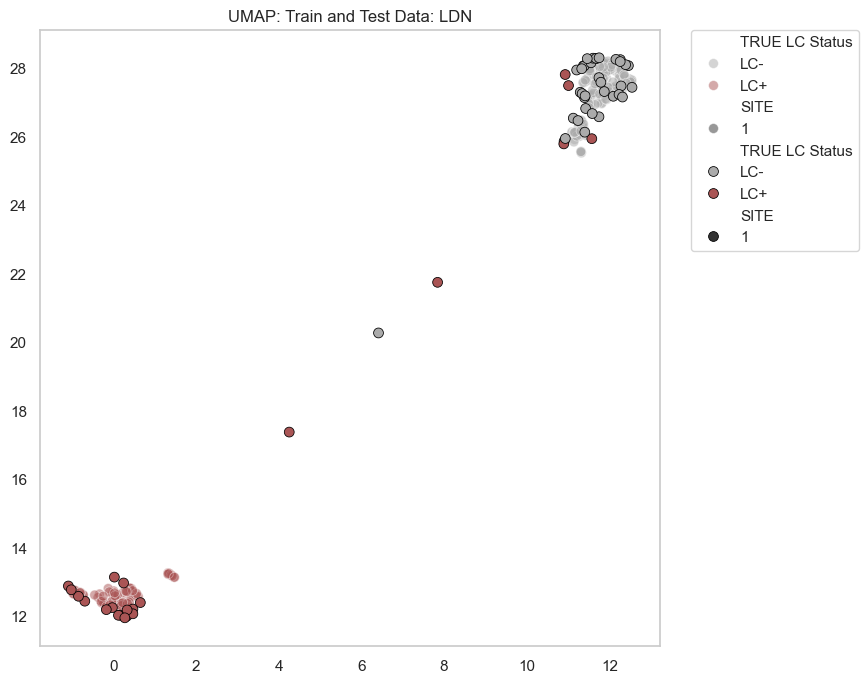

LDN accuracy:  0.91
LDN f1:        0.87
LDN precision: 1.00
LDN recall:    0.77
[[36  0]
 [ 5 17]]


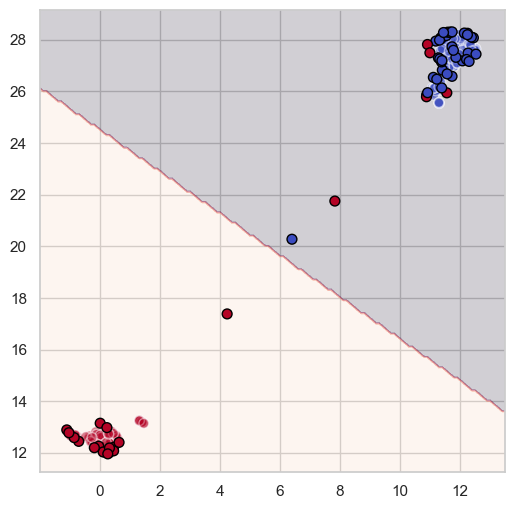

MTL data shape: (2892, 101), target shape: (2892,)
MTL X_train shape: (2313, 101), y_train shape: (2313,)
MTL X_test shape: (579, 101), y_test shape: (579,)


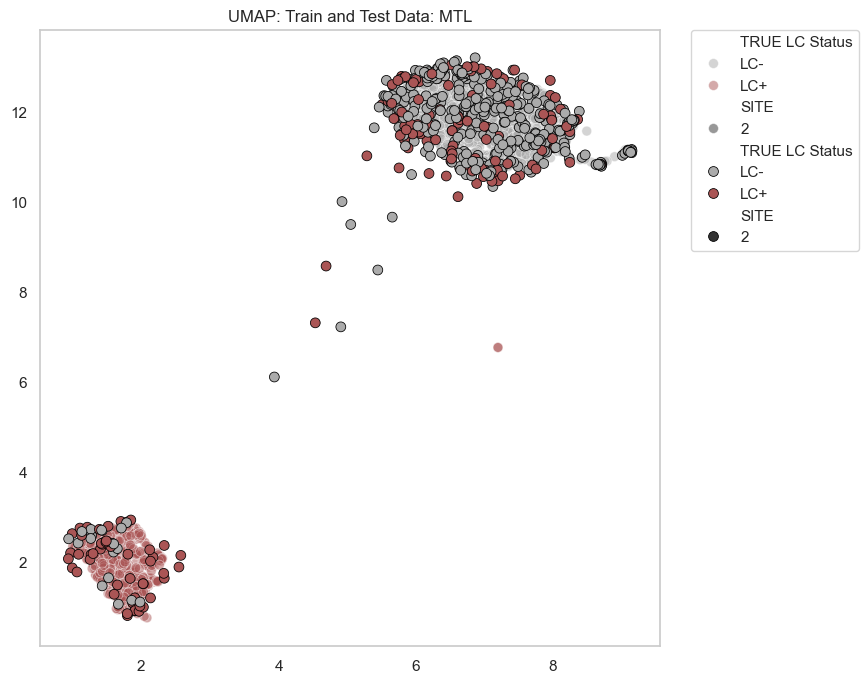

MTL accuracy:  0.74
MTL f1:        0.40
MTL precision: 0.69
MTL recall:    0.28
[[378  22]
 [129  50]]


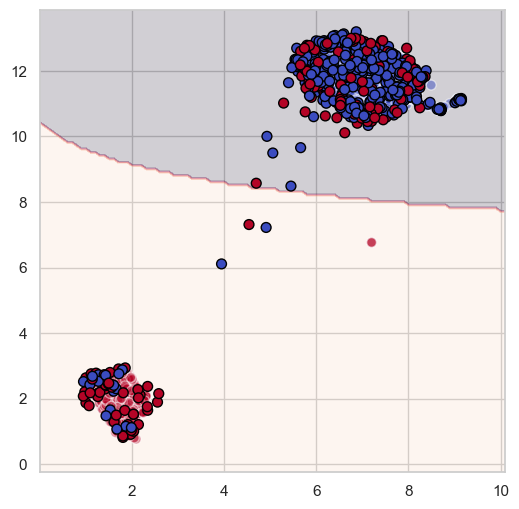

SAN data shape: (337, 98), target shape: (337,)
SAN X_train shape: (269, 98), y_train shape: (269,)
SAN X_test shape: (68, 98), y_test shape: (68,)


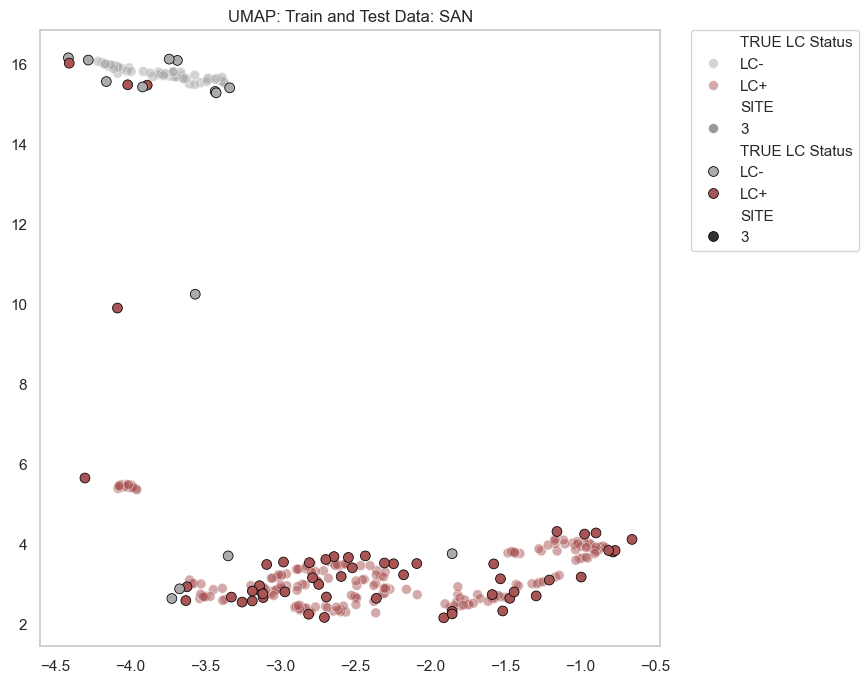

SAN accuracy:  0.88
SAN f1:        0.93
SAN precision: 0.91
SAN recall:    0.94
[[ 9  5]
 [ 3 51]]


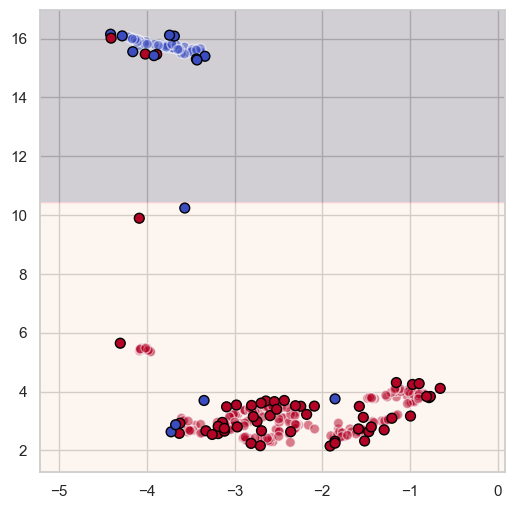

RIO data shape: (778, 65), target shape: (778,)
RIO X_train shape: (622, 65), y_train shape: (622,)
RIO X_test shape: (156, 65), y_test shape: (156,)


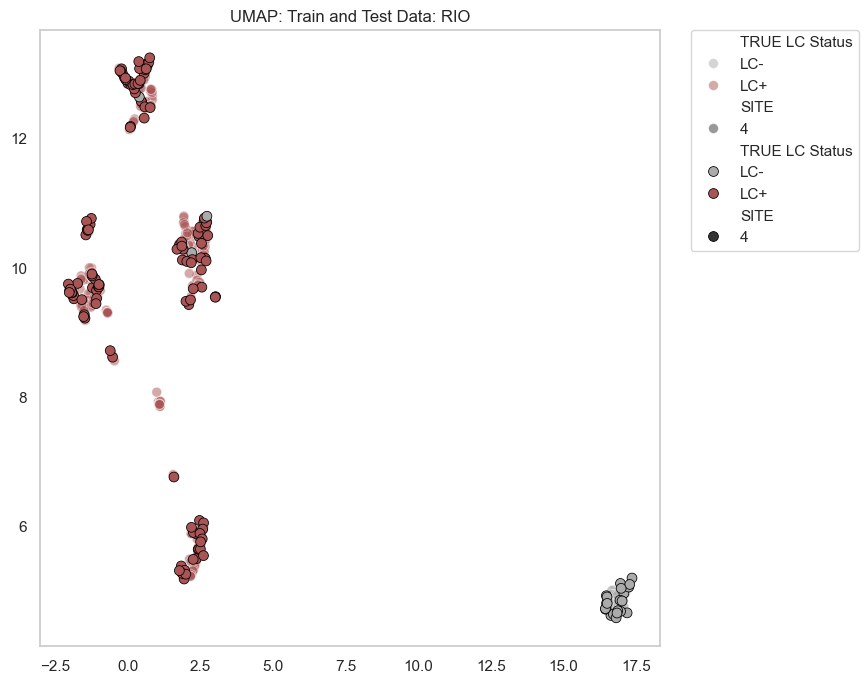

RIO accuracy:  0.97
RIO f1:        0.98
RIO precision: 0.97
RIO recall:    1.00
[[ 22   4]
 [  0 130]]


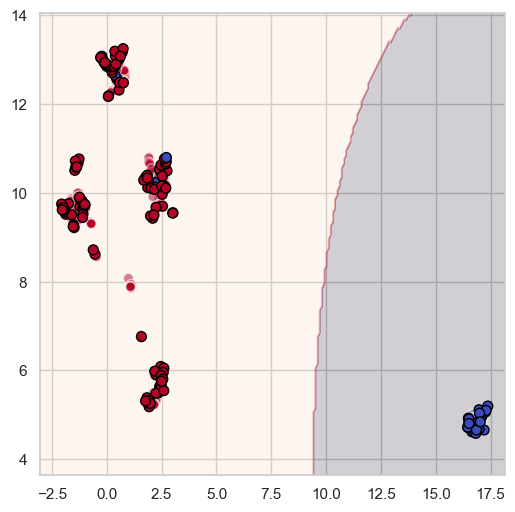

LUS data shape: (1202, 75), target shape: (1202,)
LUS X_train shape: (961, 75), y_train shape: (961,)
LUS X_test shape: (241, 75), y_test shape: (241,)


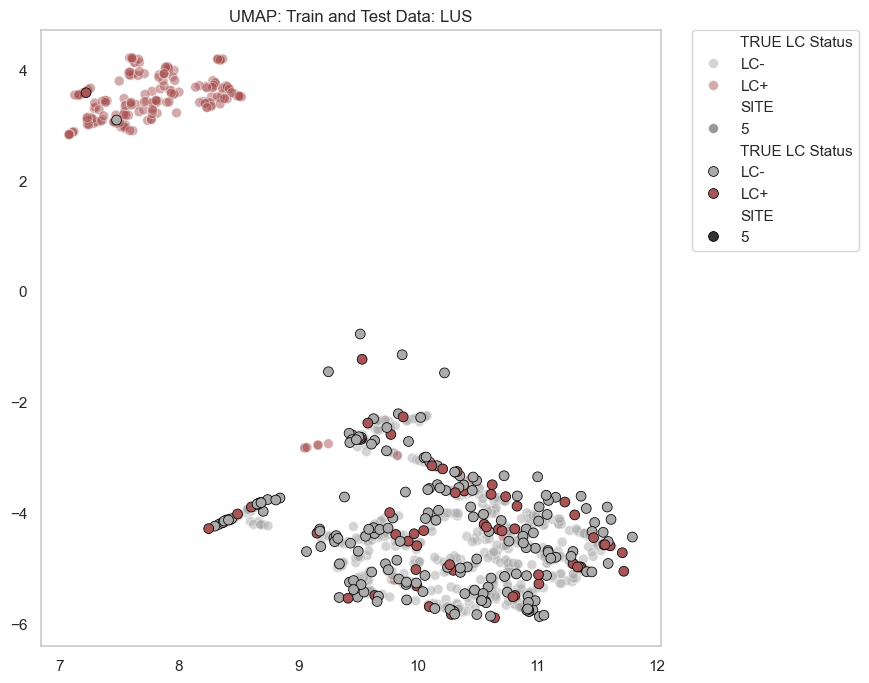

LUS accuracy:  0.78
LUS f1:        0.04
LUS precision: 0.50
LUS recall:    0.02
[[186   1]
 [ 53   1]]


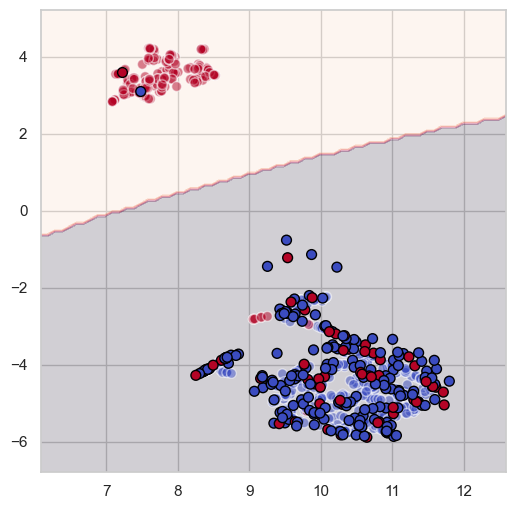

RIO-SAN-LDN data shape: (1115, 107), target shape: (1115,)
RIO-SAN-LDN X_train shape: (892, 107), y_train shape: (892,)
RIO-SAN-LDN X_test shape: (223, 107), y_test shape: (223,)


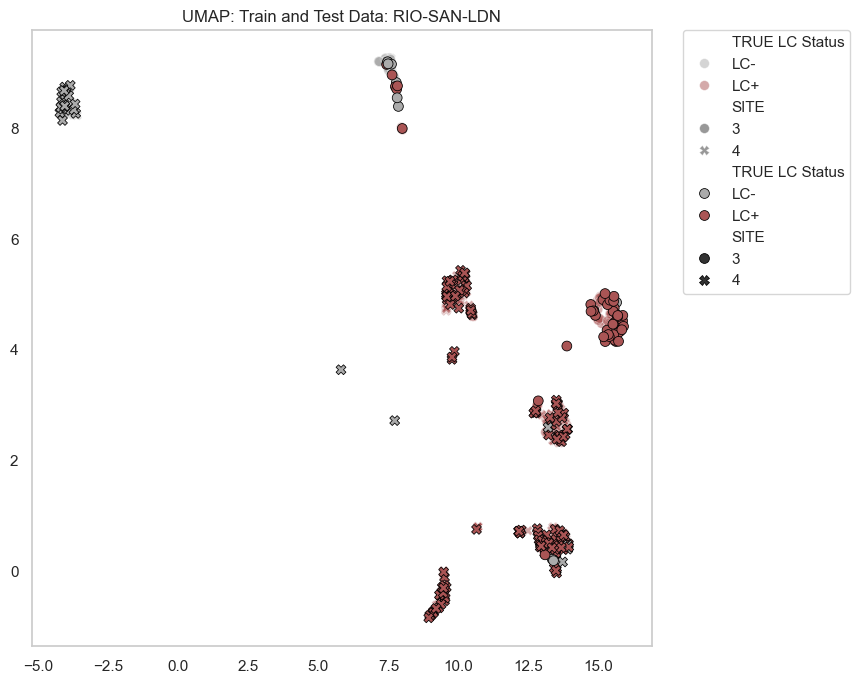

RIO-SAN-LDN accuracy:  0.93
RIO-SAN-LDN f1:        0.96
RIO-SAN-LDN precision: 0.95
RIO-SAN-LDN recall:    0.97
[[ 30  10]
 [  6 177]]


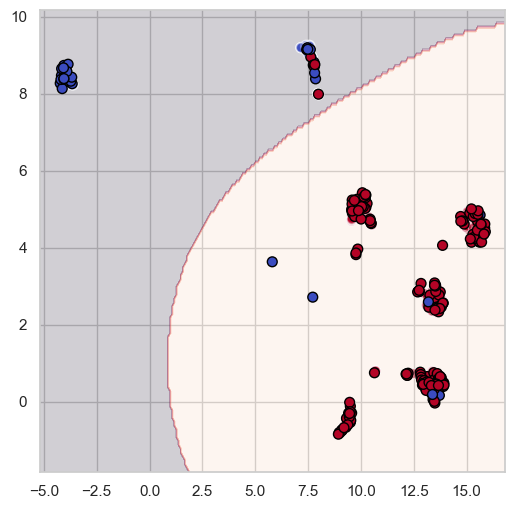

MTL-LUS data shape: (4094, 119), target shape: (4094,)
MTL-LUS X_train shape: (3275, 119), y_train shape: (3275,)
MTL-LUS X_test shape: (819, 119), y_test shape: (819,)


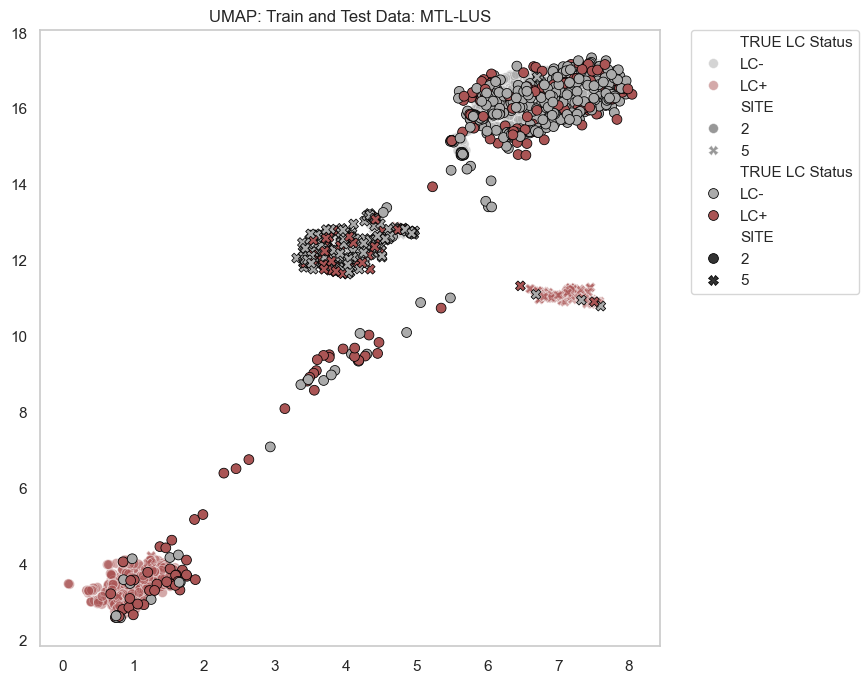

MTL-LUS accuracy:  0.75
MTL-LUS f1:        0.37
MTL-LUS precision: 0.69
MTL-LUS recall:    0.25
[[559  27]
 [174  59]]


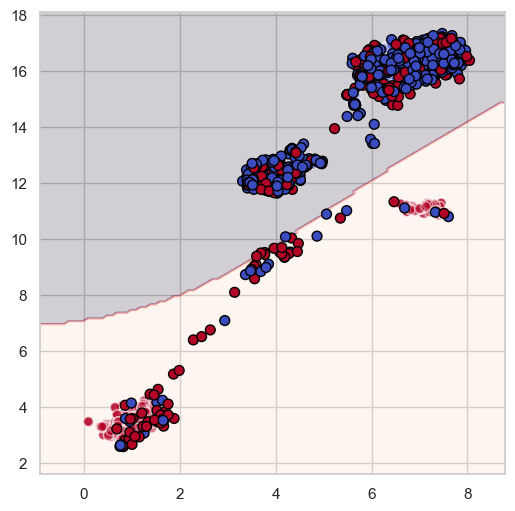

ALL-SITES data shape: (5495, 135), target shape: (5495,)
ALL-SITES X_train shape: (4396, 135), y_train shape: (4396,)
ALL-SITES X_test shape: (1099, 135), y_test shape: (1099,)


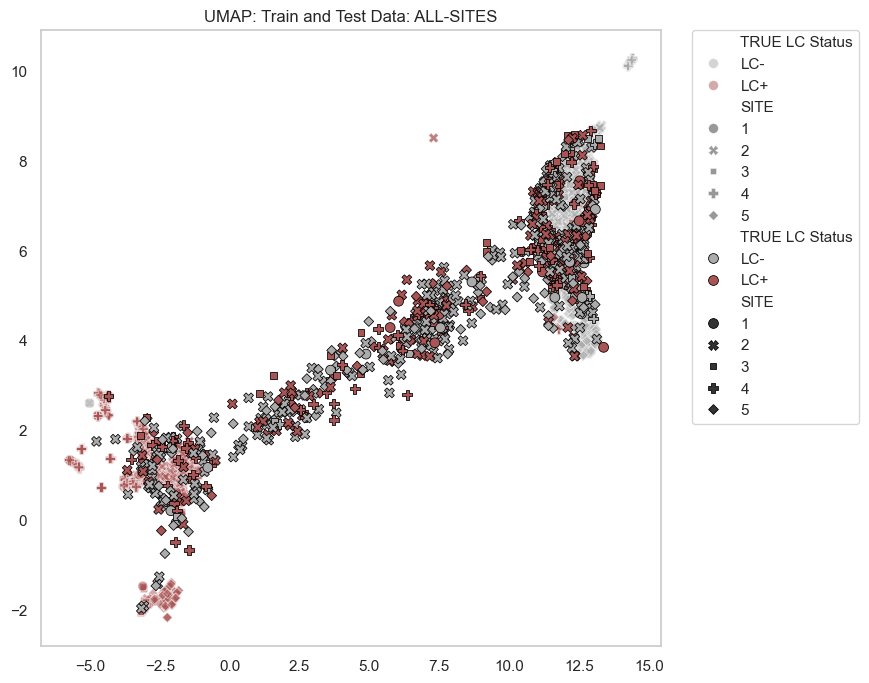

ALL-SITES accuracy:  0.54
ALL-SITES f1:        0.28
ALL-SITES precision: 0.37
ALL-SITES recall:    0.23
[[491 170]
 [338 100]]


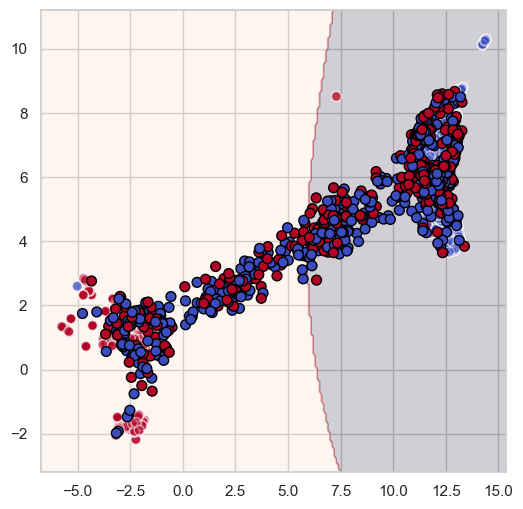

In [50]:

result_dict = {}

for key, value in data_dict.items():

    data, target = value
    
    # drop entries that are all zero
    data = data.loc[:, (data != 0).any(axis = 0)]

    # drop columns that are all the same
    data = data.loc[:, data.nunique() > 1]

    

    print(f"{key} data shape: {data.shape}, target shape: {target.shape}")
    # print(data.shape, target.shape)

    # drop the LC_STATUS from data
    try:
        data = data.drop(columns = "LC_STATUS")
    except KeyError:
        pass

    # get splits
    X_train, X_test, y_train, y_test = split_and_return(data, target, random_state = None)

    print(f"{key} X_train shape: {X_train.shape}, y_train shape: {y_train.shape}")
    print(f"{key} X_test shape: {X_test.shape}, y_test shape: {y_test.shape}")

    # print(y_train.value_counts(normalize = False))
    # print(y_test.value_counts(normalize = False))

    # reduce and return the points, labels, and clusterer
    p_train, p_test, \
    train_labels, test_labels, test_probs,\
        clusterer = reduce_and_return(
                                        X_train, 
                                        X_test, 
                                        y_train, 
                                        y_test, 
                                        metric = "euclidean",
                                        min_dist = 0.0,
                                        spread = 0.5,
                                        umap_kws = {},
                                        )

    # make a plot dataframe
    df_train, df_test = make_plot_df_2(
                                    X_train, 
                                    X_test, 
                                    p_train, 
                                    p_test, 
                                    train_labels, 
                                    test_labels, 
                                    test_probs, 
                                    df["SITE"], 
                                    y_train, 
                                    y_test,
                                    )

    make_plots(df_train, df_test, key=key, show_test = True)

    plt.savefig(f"./OUTPUT/umap-{key}.png", dpi = 300, bbox_inches = 'tight')
    plt.show()



    # svm classifier 
    from sklearn.svm import SVC

    # create a classifier
    clf = SVC(kernel = 'rbf', C = 1.0, probability = True)

    # fit the classifier
    clf.fit(p_train, y_train)

    # get the predictions

    y_pred = clf.predict(p_test)
    y_prob = clf.predict_proba(p_test)


    # get the accuracy
    from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
    from sklearn.metrics import confusion_matrix

    acc = accuracy_score(y_test, y_pred)
    cm = confusion_matrix(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)

    print(f"{key} accuracy:  {acc:0.2f}")
    print(f"{key} f1:        {f1:0.2f}")
    print(f"{key} precision: {precision:0.2f}")
    print(f"{key} recall:    {recall:0.2f}")
    print(cm)

    # print(acc)
    # print(cm)

    result_dict[key] = {"accuracy": acc, "f1": f1, "precision": precision, "recall": recall, "confusion matrix": cm}


    plot_decision_boundary(p_train, p_test, y_train, y_test, clf)
    plt.show()
    # plot_decision_boundary(p_train, p_test, y_train, y_pred, clf)
    # plt.show()

    # plt.savefig(f"./OUTPUT/decision-boundary-{key}.png", dpi = 300, bbox_inches = 'tight')



In [46]:
# make a dataframe from the result_dict
df_results = pd.DataFrame(result_dict).T
df_results

,accuracy,f1,precision,recall,confusion matrix
LDN,0.88,0.83,0.89,0.77,"[[34, 2], [5, 17]]"
MTL,0.74,0.42,0.68,0.30,"[[375, 25], [125, 54]]"
SAN,0.90,0.93,0.96,0.91,"[[12, 2], [5, 49]]"
RIO,0.99,0.99,0.98,1.00,"[[24, 2], [0, 130]]"
LUS,0.78,0.00,0.00,0.00,"[[187, 0], [54, 0]]"
RIO-SAN-LDN,0.95,0.97,0.94,0.99,"[[29, 11], [1, 182]]"
MTL-LUS,0.73,0.21,0.59,0.13,"[[565, 21], [203, 30]]"
ALL-SITES,0.57,0.30,0.42,0.23,"[[519, 142], [336, 102]]"


In [62]:
# # rename the confusion_matrix column
# df_results.rename(columns = {"confusion_matrix": "confusion matrix"}, inplace = True)

# # convert the confusion matrix to a string
# df_results["confusion matrix"] = df_results["confusion matrix"].apply(lambda x: str(x))

# # add a newline to the confusion matrix between the two rows
# df_results["confusion matrix"] = df_results["confusion matrix"].str.replace("\n", "\n\n")

# drop the confusion matrix column
df_results = df_results.drop(columns = "confusion matrix")


In [63]:
# save to latex table
df_results.to_latex("./OUTPUT/results.tex", float_format = "{:0.2f}".format)

In [123]:
X_train, X_test, y_train, y_test = split_and_return(X, tgt, 
                                                    test_size = 0.2, random_state = None)

p_train, p_test, \
    train_labels, test_labels, test_probs, \
        clusterer = reduce_and_return(
                                        X_train, 
                                        X_test, 
                                        y_train, 
                                        y_test, 
                                        umap_spread = 0.5, 
                                        umap_n_components = 5,
                                      )


In [124]:
p_train, p_test

(array([[ 7.723673  , 12.659245  ,  5.490764  , -0.6638542 ,  4.1764126 ],
        [ 9.755335  ,  7.0011535 ,  4.0136137 ,  0.59974086,  4.346217  ],
        [-3.2384543 ,  0.84941393,  7.8531322 ,  2.0422094 ,  6.419533  ],
        ...,
        [ 7.5957766 , 12.939004  ,  5.459854  , -0.9381691 ,  4.352066  ],
        [ 7.875327  , 12.840335  ,  5.4739075 , -0.7280205 ,  4.1367216 ],
        [-5.5423427 , -1.1743984 ,  8.773199  ,  0.5785082 ,  7.9086037 ]],
       dtype=float32),
 array([[ 7.8152204 , 12.876587  ,  5.278128  , -0.6238381 ,  4.164107  ],
        [ 9.767795  ,  7.464707  ,  4.14523   ,  0.25500998,  4.68431   ],
        [-3.8891702 ,  1.2084743 ,  8.126056  ,  1.4783584 ,  8.86265   ],
        ...,
        [ 7.396362  , 12.250532  ,  4.949333  , -0.972952  ,  4.370621  ],
        [ 9.8876    ,  7.059836  ,  4.0604544 ,  0.4541993 ,  4.4550986 ],
        [-5.5668283 , -1.1790172 ,  8.801462  ,  0.5729792 ,  7.9320946 ]],
       dtype=float32))

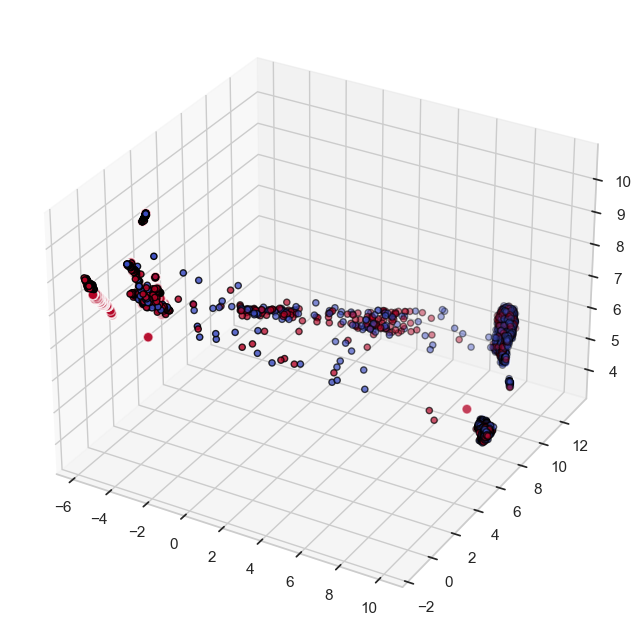

In [125]:
# 3d scatter plot
fig = plt.figure(figsize=(8,8))

ax = fig.add_subplot(111, projection='3d')

# plot the training data
ax.scatter(p_train[:, 0], p_train[:, 1], p_train[:, 2], c = y_train, cmap = 'coolwarm', edgecolor = 'w', s = 50, alpha = 0.5)

# plot the test data
ax.scatter(p_test[:, 0], p_test[:, 1], p_test[:, 2], c = y_test, cmap = 'coolwarm', edgecolor = 'k', s = 20)

In [126]:
print(X_train.shape, X_test.shape)

(2747, 135) (2748, 135)


In [127]:
# make a plot dataframe
df_train, df_test = make_plot_df_2(
                                    X_train, 
                                    X_test, 
                                    p_train, 
                                    p_test, 
                                    train_labels, 
                                    test_labels, 
                                    test_probs, 
                                    df["SITE"], 
                                    y_train, 
                                    y_test,
                                )

p_train has more than 3 columns


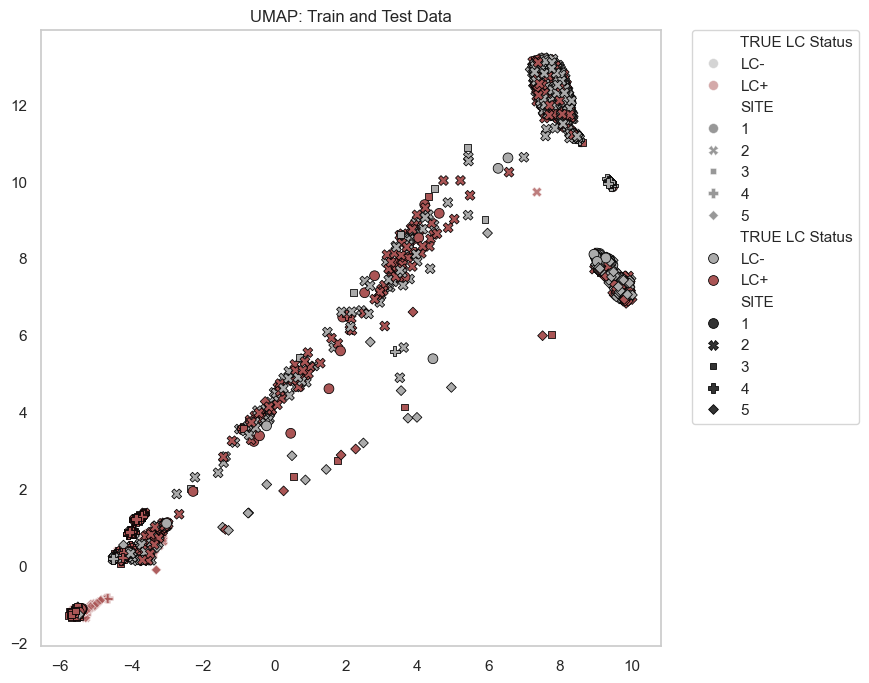

In [130]:
make_plots(df_train, df_test, show_test = True)

In [132]:
X.shape, tgt.shape,\
X_train.shape, y_train.shape, \
X_test.shape, y_test.shape

((5495, 135), (5495,), (2747, 135), (2747,), (2748, 135), (2748,))

# RFC Methods


In [85]:
# make an RFC classifier

from sklearn.ensemble import RandomForestClassifier

# get xgboost classifier
from xgboost import XGBClassifier



# create a classifier
clf = RandomForestClassifier(n_estimators = 100, 
                             max_depth = 7, 
                             random_state = 42)

clf = XGBClassifier(n_estimators = 100, 
                    max_depth = 7, 
                    random_state = 42)

# fit the classifier


# use 10-fold cross validation
from sklearn.model_selection import cross_val_score, cross_validate

# get the cross validation scores
# scores = cross_val_score(clf, X, tgt, cv = 10, scoring = "roc_auc")

result = cross_validate(clf, X_train, y_train, cv = 10, scoring = "roc_auc", return_estimator = True, return_train_score = True)


# clf.fit(p_train, y_train)
clf.fit(X_train, y_train)

# get the best parameters
# clf.best_params_


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=7, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=100, n_jobs=None,
              num_parallel_tree=None, random_state=42, ...)

In [86]:
for e in result["estimator"]:
    # print(e)
    yy_pred = e.predict(X_test)

    cm = confusion_matrix(y_test, yy_pred)
    print(cm)

    print(accuracy_score(y_test, yy_pred))

[[636  25]
 [ 46 392]]
0.935395814376706
[[629  32]
 [ 51 387]]
0.924476797088262
[[632  29]
 [ 47 391]]
0.9308462238398544
[[632  29]
 [ 52 386]]
0.9262966333030027
[[627  34]
 [ 47 391]]
0.9262966333030027
[[631  30]
 [ 48 390]]
0.9290263876251137
[[633  28]
 [ 45 393]]
0.9335759781619655
[[635  26]
 [ 47 391]]
0.9335759781619655
[[633  28]
 [ 44 394]]
0.9344858962693358
[[632  29]
 [ 47 391]]
0.9308462238398544


In [89]:

# predict the test data
y_pred = clf.predict(X_test)
y_prob = clf.predict_proba(X_test)

# get the accuracy
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, roc_auc_score

acc       = accuracy_score(y_test, y_pred)
f1        = f1_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall    = recall_score(y_test, y_pred)
roc_auc   = roc_auc_score(y_test, y_pred)

print(f"accuracy:  {acc:0.2f}")
print(f"f1:        {f1:0.2f}")
print(f"precision: {precision:0.2f}")
print(f"recall:    {recall:0.2f}")
print(f"roc_auc:   {roc_auc:0.2f}")



accuracy:  0.92
f1:        0.90
precision: 0.92
recall:    0.89
roc_auc:   0.92
